# Quick demo of the HealPixRegridder

HealPix regridding is automatically applied during clustering for datasets with latitude/longitude coordinates.


In [4]:
# Prerequisites
import numpy as np
from toad import TOAD
from sklearn.cluster import HDBSCAN
from toad.regridding import HealPixRegridder
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from toad.shifts import ASDETECT

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (12, 5)

In [ ]:
td = TOAD("test_data/global_mean_summer_tas.nc", log_level="INFO")
td.data = td.data.coarsen(lat=2, lon=2, boundary="trim").reduce(np.mean)

In [5]:
td.compute_shifts("tas", method=ASDETECT(), overwrite=True)

INFO: Applying detector ASDETECT to tas


In [ ]:
#  Regular latitude/longitude grids have denser sampling near the poles,
# which can bias clustering results. So for lat/lon coords, a regridder
# is applied by default: the HealPixRegridder.
regridder = HealPixRegridder()

# So you don't need to pass it, like is done here, but if you do you can also access the cluster results in the healpix grid, see 3 cells below.
td.compute_clusters(
    "tas",
    method=HDBSCAN(min_cluster_size=10),
    shift_threshold=0.6,
    overwrite=True,
    regridder=regridder,
)
# Takes 3.0 on my laptop

print(f"Identified clusters: {td.get_cluster_ids('tas')}")

INFO: Regridding tas_dts with HealPixRegridder
INFO: Applying clusterer HDBSCAN to tas_dts
INFO: Detected 30 clusters


Identified clusters: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


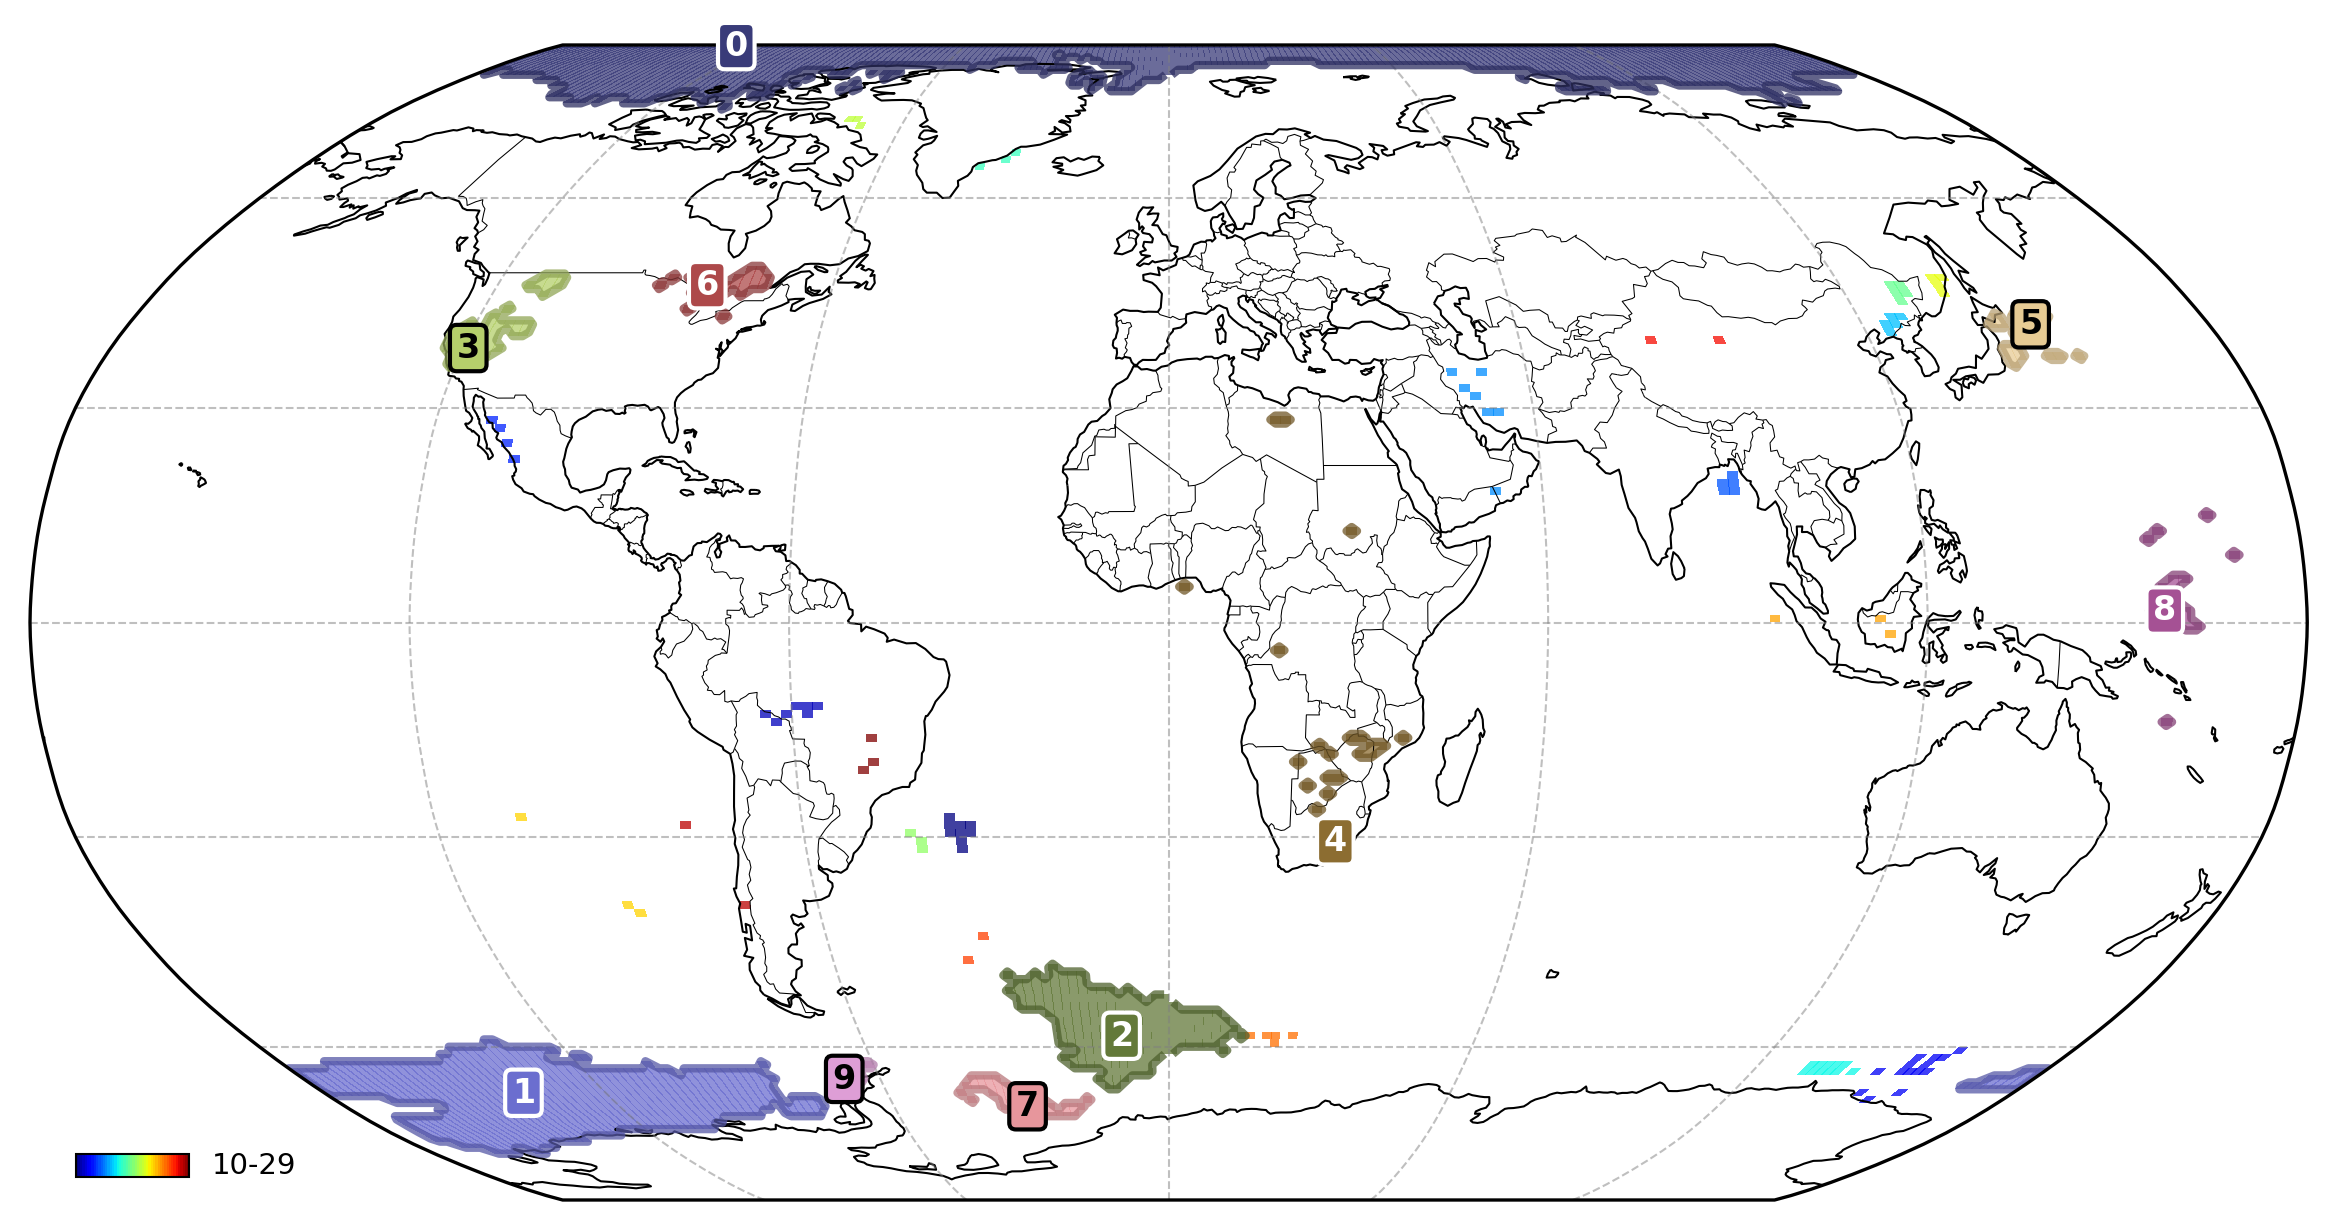

In [7]:
td.plotter().cluster_map("tas", cluster_ids=range(10), projection="global");

,time,hp_pix,vals,lat,lon,cluster
0,2020.0,36706,0.625000,-29.313199,317.812500,20
1,2020.0,46564,0.625000,-63.448284,191.250000,29
2,2020.0,46566,0.666667,-63.448284,196.250000,29
3,2020.0,46568,0.625000,-63.448284,201.250000,29
4,2020.0,46706,0.666667,-64.198746,191.571429,29
...,...,...,...,...,...,...
11630,2096.0,462,0.666667,79.018714,255.000000,16
11631,2096.0,524,0.666667,78.284148,250.312500,16
11632,2096.0,525,0.666667,78.284148,255.937500,16
11633,2096.0,591,0.625000,77.549098,251.470588,16


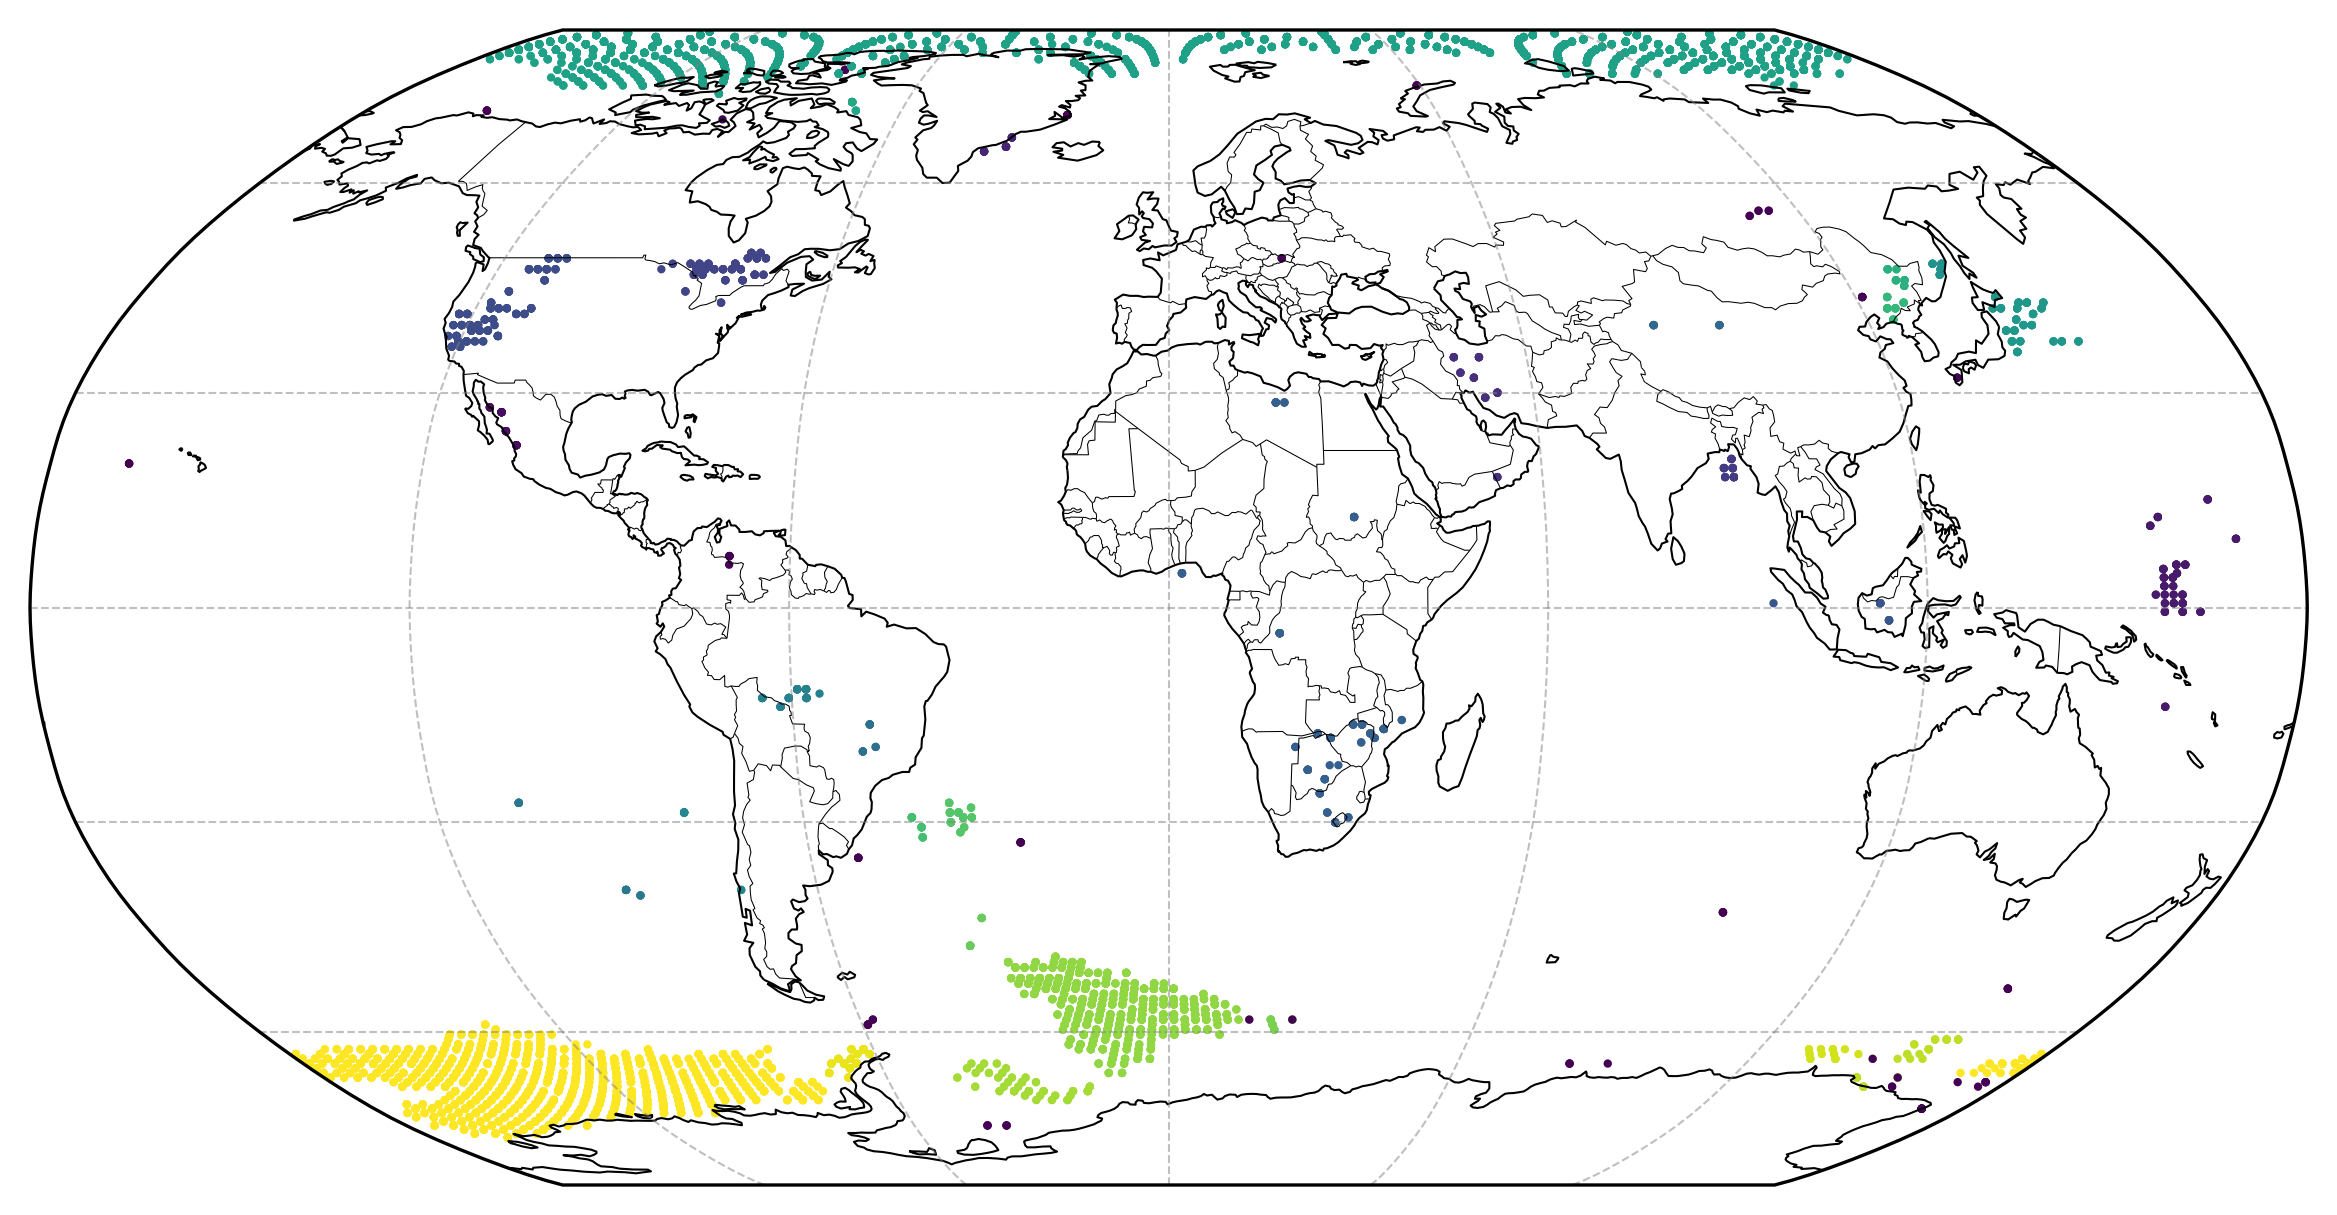

In [8]:
# we can also access the clusters in the healpix grid
display(regridder.df_healpix)

# and plot the data in the healpix grid
lats, lons, cluster = (
    regridder.df_healpix.lat,
    regridder.df_healpix.lon,
    regridder.df_healpix.cluster,
)
fig, ax = td.plotter().map(projection="global")
ax.scatter(lons, lats, c=cluster, s=1, transform=ccrs.PlateCarree())